In [1]:
from tensorflow.keras import backend as K
K.clear_session()
!pip install rarfile
import os
import pandas as pd
import gdown
import rarfile
import shutil
from PIL import Image

#https://drive.google.com/file/d/1O0_qr4yHPDp_O36wS59mVvyYiX3c9pYk/view?usp=drive_link



url = 'https://drive.google.com/uc?id=1O0_qr4yHPDp_O36wS59mVvyYiX3c9pYk'
output_rar = '/content/SDR.rar'
gdown.download(url, output_rar, quiet=False)
# Extract the RAR file
with rarfile.RarFile(output_rar, 'r') as rar_ref:
    rar_ref.extractall('/content')
# Path to the extracted dataset folder
dataset_folder = '/content/SDR'

Downloading...
From (original): https://drive.google.com/uc?id=1O0_qr4yHPDp_O36wS59mVvyYiX3c9pYk
From (redirected): https://drive.google.com/uc?id=1O0_qr4yHPDp_O36wS59mVvyYiX3c9pYk&confirm=t&uuid=7c85723b-79d8-4402-a856-a59b063f1f57
To: /content/SDR.rar
100%|██████████| 231M/231M [00:05<00:00, 41.5MB/s]


## ResNet50

In [8]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Activation, BatchNormalization, Add, AveragePooling2D, Flatten, Dense

def conv_block(inputs, filters, kernel_size, strides=(1, 1)):
    x = Conv2D(filters=filters[0], kernel_size=(1, 1), strides=strides, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters=filters[1], kernel_size=(3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters=filters[2], kernel_size=(1, 1), padding='same')(x)
    x = BatchNormalization()(x)

    shortcut = Conv2D(filters=filters[2], kernel_size=(1, 1), strides=strides, padding='same')(inputs)
    shortcut = BatchNormalization()(shortcut)

    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

def identity_block(inputs, filters):
    x = Conv2D(filters=filters[0], kernel_size=(1, 1), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters=filters[1], kernel_size=(3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters=filters[2], kernel_size=(1, 1), padding='same')(x)
    x = BatchNormalization()(x)

    x = Add()([x, inputs])
    x = Activation('relu')(x)
    return x

def resnet_50():
    inputs = Input(shape=(224, 224, 3))

    # Initial layers
    x = Conv2D(64, (7, 7), strides=(2, 2), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    # Residual blocks
    x = conv_block(x, [64, 64, 256], (3, 3))
    for _ in range(2):
        x = identity_block(x, [64, 64, 256])

    x = conv_block(x, [128, 128, 512], (3, 3), strides=(2, 2))
    for _ in range(3):
        x = identity_block(x, [128, 128, 512])

    x = conv_block(x, [256, 256, 1024], (3, 3), strides=(2, 2))
    for _ in range(5):
        x = identity_block(x, [256, 256, 1024])

    x = conv_block(x, [512, 512, 2048], (3, 3), strides=(2, 2))
    for _ in range(2):
        x = identity_block(x, [512, 512, 2048])

    # Final layers
    x = AveragePooling2D((7, 7))(x)
    x = Flatten()(x)
    outputs = Dense(5, activation='softmax')(x)

    resnet50 = Model(inputs=inputs, outputs=outputs)
    resnet50.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return resnet50

model = resnet_50()
model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_76 (Conv2D)  │ (None, 112, 112,  │      9,472 │ input_layer_3[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_76[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_66       │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 56, 56,    │          0 │ activation_66[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_77 (Conv2D)  │ (None, 56, 56,    │      4,160 │ max_pooling2d_5[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_77[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_67       │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_78 (Conv2D)  │ (None, 56, 56,    │     36,928 │ activation_67[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_78[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_68       │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_79 (Conv2D)  │ (None, 56, 56,    │     16,640 │ activation_68[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_80 (Conv2D)  │ (None, 56, 56,    │     16,640 │ max_pooling2d_5[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │      1,024 │ conv2d_79[0][0]   │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │      1,024 │ conv2d_80[0][0]   │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_24 (Add)        │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 256)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_69       │ (None, 56, 56,    │          0 │ add_24[0][0]    

 Total params: 23,597,957 (90.02 MB)

 Trainable params: 23,544,837 (89.82 MB)

 Non-trainable params: 53,120 (207.50 KB)

# **Fold#1** Train ResNet-50

Found 2674 images belonging to 3 classes.
Found 666 images belonging to 3 classes.
Epoch 1/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.6340 - loss: 1.4402
Epoch 1: val_accuracy improved from -inf to 0.78078, saving model to /content/Split/Save/best_model.keras
84/84 ━━━━━━━━━━━━━━━━━━━━ 23s 191ms/step - accuracy: 0.6348 - loss: 1.4334 - val_accuracy: 0.7808 - val_loss: 0.5647
Epoch 2/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.7464 - loss: 0.6355
Epoch 2: val_accuracy did not improve from 0.78078
84/84 ━━━━━━━━━━━━━━━━━━━━ 10s 120ms/step - accuracy: 0.7464 - loss: 0.6355 - val_accuracy: 0.7733 - val_loss: 0.5625
Epoch 3/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.7467 - loss: 0.6006
Epoch 3: val_accuracy did not improve from 0.78078
84/84 ━━━━━━━━━━━━━━━━━━━━ 10s 115ms/step - accuracy: 0.7468 - loss: 0.6007 - val_accuracy: 0.7492 - val_loss: 0.5611
Epoch 4/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.7654 - loss: 0.5815
Epoch 4: val_a

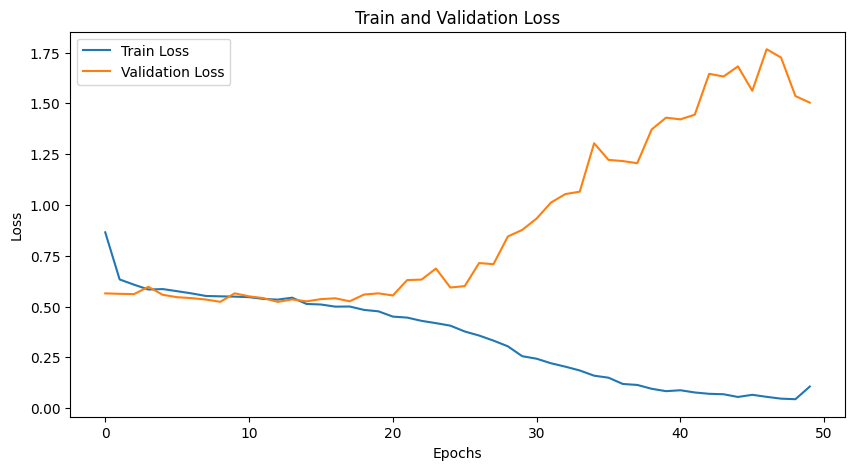

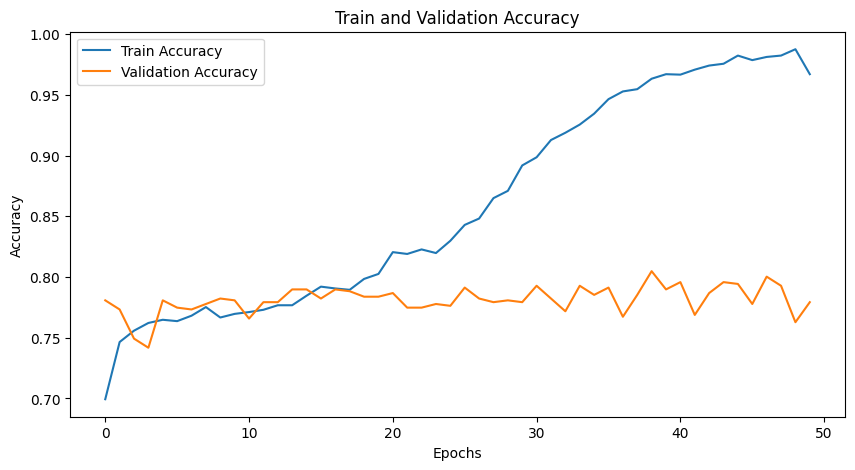

In [9]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Define dataset path
data_dir = '/content/Gradding 3C/Train'
class_names = ['Healthy', 'Mild-to-Moderate', 'Severe-to-Proleferative' ]
img_size = (224, 224)
batch_size = 32
epochs = 50

# Check if dataset directory exists
if not os.path.exists(data_dir):
    raise FileNotFoundError(f"Error: Dataset directory '{data_dir}' not found. Please check the path.")

# Data generators for training and validation
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Training data generator
train_data_generator = datagen.flow_from_directory(
    data_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical', shuffle=True, subset='training'
)

# Validation data generator
validation_data_generator = datagen.flow_from_directory(
    data_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical', shuffle=True, subset='validation'
)

# Define the model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_size[0], img_size[1], 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')  # ✅ Corrected: 5 neurons for 5 classes
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define checkpoint callback (corrected filename format)
best_weights_path = '/content/Split/Save/best_model.keras'  # ✅ Corrected: .keras extension
checkpoint = ModelCheckpoint(best_weights_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# Train the model
history = model.fit(train_data_generator, epochs=epochs, validation_data=validation_data_generator, verbose=1, callbacks=[checkpoint])

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Train and Validation Loss')
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Train and Validation Accuracy')
plt.show()


# **Fold#1** Test ResNet-50

In [10]:
import os
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load the saved best weights
best_weights_path = '/content/Split/Save/best_model.keras'
model.load_weights(best_weights_path)

# Define the dataset directory
TestSet = '/content/Gradding 3C/Test'

# Create an ImageDataGenerator for test data
datagen = ImageDataGenerator(rescale=1.0/255)  # You can add other preprocessing steps here

test_data_generator = datagen.flow_from_directory(
    TestSet,
    target_size=img_size,  # Set your target image size (e.g., (224, 224))
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Do not shuffle the test data
)

# Get true labels and predicted labels
y_true = test_data_generator.classes
y_pred = np.argmax(model.predict(test_data_generator), axis=1)

# Calculate evaluation metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print("Test Accuracy:", accuracy)
print("Test Precision:", precision)
print("Test Recall:", recall)
print("Test F1-score:", f1)

# Calculate and display the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(conf_matrix)


Found 838 images belonging to 3 classes.
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step
Test Accuracy: 0.7804295942720764
Test Precision: 0.7735751742101896
Test Recall: 0.7804295942720764
Test F1-score: 0.7760382525688634
Confusion Matrix:
[[359  22  14]
 [ 20 247  46]
 [ 13  69  48]]
